# Clifford Group Equivariant Neural Networks

This is a quick introduction to Clifford group equivariant layers can be used. First, let's do some imports.

In [1]:
%cd ..

/home/druhe/github/clifford-group-equivariant-networks


# Imports

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

from models.modules.fcgp import FullyConnectedSteerableGeometricProductLayer
from models.modules.gp import SteerableGeometricProductLayer
from models.modules.linear import MVLinear
from models.modules.mvsilu import MVSiLU
from models.modules.mvlayernorm import MVLayerNorm

from algebra.cliffordalgebra import CliffordAlgebra

# Setup

Next, let's create some fake data. We assume we have 8 three-dimensional vectors and 8 scalar input data. We leave the batch dimension to 1.

In [3]:
h = torch.randn(1, 8, 1)
x = torch.randn(1, 8, 3)

Let's create the three-dimensional Clifford algebra.

In [4]:
algebra = CliffordAlgebra((1., 1., 1.))

We embed the data in the algebra. Scalars are of grade 0, and vectors of grade 1. We concatenate the input features.

In [5]:
h_cl = algebra.embed_grade(h, 0)
x_cl = algebra.embed_grade(x, 1)

input = torch.cat([h_cl, x_cl], dim=1)

# Create Orthogonal Transformations

Let's apply some orthogonal transformations. As shown in the paper, the Clifford group can do that for us.

In [6]:
# Reflector
v = algebra.versor(1)

# Rotor
R = algebra.versor(2)

Create reflected and rotated versions of the data.

In [7]:
input_v = algebra.rho(v, input.clone())

input_R = algebra.rho(R, input.clone())

Make sure that the transformations are orthogonal.

In [8]:
assert torch.allclose(algebra.norm(input_v), algebra.norm(input))
assert torch.allclose(algebra.norm(input_R), algebra.norm(input))


# Create Network Layers

Now, we create some layers.

In [9]:
fcgp = FullyConnectedSteerableGeometricProductLayer(algebra, 16, 1)
gp = SteerableGeometricProductLayer(algebra, 16)
linear = MVLinear(algebra, 16, 16)
mvsilu = MVSiLU(algebra, 16)
norm = MVLayerNorm(algebra, 16)

# Equivariance Checks

Let's check the equivariance!

In [10]:
output = fcgp(input)
output_v = fcgp(input_v)
output_R = fcgp(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

And a visualization of the equivariance.

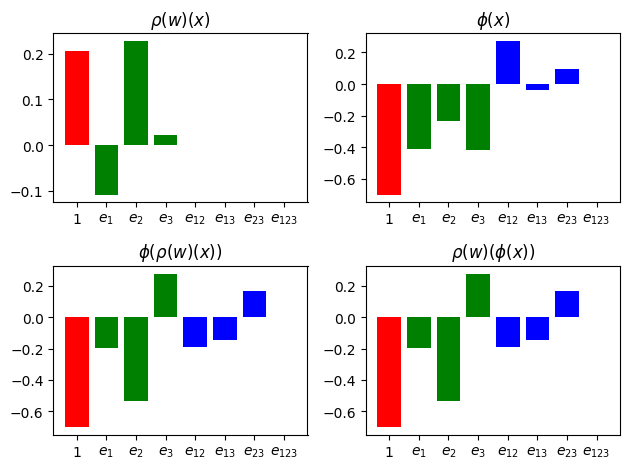

In [11]:
# Labels
x = ['$1$', '$e_1$', '$e_2$', '$e_3$', '$e_{12}$', '$e_{13}$', '$e_{23}$', '$e_{123}$']
fig, axes = plt.subplots(nrows=2, ncols=2)

# First bar chart (top left)
axes[0, 0].bar(x, input_R[0, :].mean(0).detach(), color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[0, 0].set_title(r"$\rho(w)(x)$")

# Second bar chart (top right)
axes[0, 1].bar(x, fcgp(input)[0].mean(0).detach(), color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[0, 1].set_title(r"$\phi(x)$")

# Third bar chart (bottom left)
axes[1, 0].bar(x, algebra.rho(R, output).detach()[0, 0], color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[1, 0].set_title(r"$\phi(\rho(w)(x))$")

# Fourth bar chart (bottom right)
axes[1, 1].bar(x, output_R.detach()[0, 0], color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[1, 1].set_title(r"$\rho(w)(\phi(x))$")

plt.tight_layout()
plt.show()


In [12]:
output = gp(input)
output_v = gp(input_v)
output_R = gp(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

In [13]:
output = linear(input)
output_v = linear(input_v)
output_R = linear(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

In [14]:
output = mvsilu(input)
output_v = mvsilu(input_v)
output_R = mvsilu(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

In [15]:
output = norm(input)
output_v = norm(input_v)
output_R = norm(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

# Mix and Match!

And we're done! One can now use these layers to compose equivariant deep neural networks. Need some inspiration? Check the `models` directory!